In [3]:
#Import modules
import random 
import numpy as np
import pandas as pd 
import uuid
import matplotlib.pyplot as plt 

In [4]:
# Create default functions
def DefaultChoose(*argv, **kwargs):
    return bool(random.getrandbits(1))
    
def DefaultLearn(*argv, **kwargs):
    pass

In [5]:
# Create Class for the bots
class pBot:
    
    def __init__(self, learn = DefaultLearn, choose = DefaultChoose, name = np.nan, **kwargs):
        self.learn = learn
        self.choose = choose
        self.score = 0
        self.gamesplayed = 0
        
        if kwargs is not None:
            for key, value in kwargs.items():
                setattr(self, key, value)
    
        self.gamelist = pd.DataFrame(columns=['cooperation'
                                              ,'desertion'
                                              ,'being_deserted'
                                              ,'mutual_desertion'
                                              ,'nth'
                                              ,'interaction_length'
                                              ,'partner_id'
                                              ,'own_choice'
                                              ,'partner_choice'])
        
        self.id = str(uuid.uuid4())
        self.name = self.id if pd.isnull(name) else name
        
        
        
    def evaluate(self, pointdict, nth, interaction_length, partner_id, own_choice, partner_choice):
        if own_choice not in [1,0] or partner_choice  not in [1,0]:
            raise ValueError('Error: Bot response not boolean.')
                    
        if own_choice == 1:
            if partner_choice == 1:
                self.score += pointdict['cooperation']
                    
            if partner_choice == 0: 
                self.score += pointdict['being_deserted']
                    
        if own_choice == 0:
            if partner_choice == 1:
                self.score += pointdict['cooperation']
                    
            if partner_choice == 0: 
                self.score += pointdict['being_deserted']
        
        row = [pointdict['cooperation'], pointdict['desertion'], pointdict['being_deserted'], pointdict['mutual_desertion']]
        row += [nth, interaction_length, partner_id, own_choice, partner_choice]
        
        self.gamelist.loc[self.gamesplayed]=  row #appending row
        self.gamesplayed += 1

In [6]:
# Default generator for the rules of an interaction
# You may create your own generator 

def DefaultGenerator():
    glist = sorted([random.uniform(0, 100) for i in range(3)], reverse = True)
    
    Gdict = {}
    Gdict['cooperation'] = random.uniform(0, 100)
    Gdict['desertion'] = random.uniform(Gdict['cooperation']/2, Gdict['cooperation'])
    Gdict['cooperation'] /= 2
    Gdict['being_deserted'] = random.uniform(0, min(Gdict['desertion'],Gdict['cooperation']))
    Gdict['mutual_desertion'] = random.uniform(0, min(Gdict['desertion'],Gdict['cooperation']))
    
    return Gdict

In [7]:
# Create frame function for a given number of interaction between bots
def Interact(bot1 = pBot()
             , bot2 = pBot()
             , ntimes = 1
             , show_ntimes = False
             , generator = DefaultGenerator
             , interact_id = 0
             , verbose = 0
             , vis = 0):
    
    bot1score_i = bot1.score
    bot2score_i = bot2.score
    b1sclist = []
    b2sclist = []
    nth = 0
    for i in range(ntimes):
        if verbose == 2:
            print('Interaction Number {}.-------------------------'.format(nth))
        Gdict = generator()
        
        if verbose == 2:
            for i in Gdict:
                print('{}: {}'.format(i, Gdict[i]))
            print('\n')
            
        shown_ntimes = ntimes if show_ntimes == True else np.nan
        bot1Choice = bot1.choose(bot1, Gdict, nth, shown_ntimes)
        bot2Choice = bot2.choose(bot2, Gdict, nth, shown_ntimes)
        
        if verbose == 2:
            print('{} choice: {} \n{} choice: {}'.format(bot1.name, bot1Choice, bot2.name, bot2Choice))
            
        bot1.evaluate(pointdict = Gdict
                      ,nth = nth
                      ,interaction_length = shown_ntimes
                      ,partner_id = bot1.id
                      ,own_choice = bot1Choice
                      ,partner_choice = bot2Choice)
        
        bot2.evaluate(pointdict = Gdict
                      ,nth = nth
                      ,interaction_length = shown_ntimes
                      ,partner_id = bot2.id
                      ,own_choice = bot2Choice
                      ,partner_choice = bot1Choice)
        
        bot1.learn(bot1, nth)
        bot2.learn(bot2, nth)
        
        nth += 1
        if verbose == 2:
            print('\n')
        
        b1sclist.append(bot1.score-bot1score_i)
        b2sclist.append(bot2.score-bot2score_i)
    if verbose >= 1:
        print('Interaction series no {}. overview-------------------------'.format(interact_id))
        print('{} gained {} points'.format(bot1.name, bot1.score-bot1score_i))
        print('{} gained {} points'.format(bot2.name, bot2.score-bot2score_i))
        print('{} cooperativity: {}'.format(bot1.name, np.mean(bot1.gamelist['own_choice'].tail(ntimes))))
        print('{} cooperativity: {}'.format(bot2.name, np.mean(bot2.gamelist['own_choice'].tail(ntimes))))
    if vis == 1:
        df = pd.DataFrame({'bot1': bot1.gamelist['own_choice'].tail(ntimes)
                           ,'bot2': bot1.gamelist['own_choice'].tail(ntimes)
                           ,'bot1 score':b1sclist
                           ,'bot2 score':b2sclist})
        
        df['CoopAvg']= (df['bot1'] + df['bot2'])/2
        df['CoopAvg']= pd.rolling_mean(df['CoopAvg'], 10)
        fig = plt.figure(figsize = (10,7.5))
        
        
        plt.title('Match overview between {} and {}'.format(bot1.name, bot2.name))
        df['bot1 score'].plot(label='{} score'.format(bot1.name))
        df['bot2 score'].plot(label='{} score'.format(bot2.name))
        df['CoopAvg'].plot(secondary_y=True, label='CoopAvg')
        
        fig.legend(loc=0)
        plt.show()
        return df

In [9]:
# Test basic bots and interactions
DefaultBot = pBot(name = 'Default1')
DefaultBot2 = pBot(name = 'Default2')

Interact(DefaultBot,DefaultBot2, 5, verbose = True)
DefaultBot2.gamelist

Interaction series no 0. overview-------------------------
Default1 gained 52.35734149647037 points
Default2 gained 69.43425355658945 points
Default1 cooperativity: 0.6
Default2 cooperativity: 0.4


,cooperation,desertion,being_deserted,mutual_desertion,nth,interaction_length,partner_id,own_choice,partner_choice
0,3.724091,5.936196,0.840899,3.589658,0,NaN,c351e397-6b2a-4efc-a55b-21a1914e4a40,True,False
1,26.516062,45.649587,1.144977,16.390963,1,NaN,c351e397-6b2a-4efc-a55b-21a1914e4a40,True,True
2,27.607805,40.397302,8.055424,19.496937,2,NaN,c351e397-6b2a-4efc-a55b-21a1914e4a40,False,True
3,3.097314,3.893940,2.689590,2.380845,3,NaN,c351e397-6b2a-4efc-a55b-21a1914e4a40,False,True
4,35.810070,64.054081,11.372174,0.401314,4,NaN,c351e397-6b2a-4efc-a55b-21a1914e4a40,False,False


In [10]:
# Create bot with default hardcoded strategy
# The forgiving punisher opens with cooperation, and then repeats the last step of its partner
def ForgivingPunish(self, dict, nth, *argv, **kvargs):
    if nth == 0:
        return True
    
    return self.gamelist['partner_choice'].values[-1]

ForgivingPunisher = pBot(choose = ForgivingPunish ,name = 'ForgivingPunisher')

In [11]:
# The desertion calculator compares the punishment for mutual desertion or being deserted while cooperating 
def Calc1(self, dict, nth, *argv, **kvargs):
    if dict['being_deserted'] > dict['mutual_desertion']:
        return True
    
    return False

DesertionCalculator = pBot(choose = Calc1, name = 'DesertionCalculator')

In [12]:
# The Simple calculator only takes the dict into account 
def Calc2(self, dict, nth, *argv, **kvargs):
    if dict['being_deserted']+dict['cooperation'] > dict['mutual_desertion']+dict['desertion']:
        return True
    
    return False

SimpleCalculator = pBot(choose = Calc2, name = 'SimpleCalculator')

In [13]:
# Always desert
def Desert(*argv, **kvargs):
    return False

BlindDeserter = pBot(choose = Desert, name = 'BlindDeserter')

In [14]:
# Always cooperate
def Cooperate(*argv, **kvargs):
    return True

BlindCooperator = pBot(choose = Cooperate, name = 'BlindCooperator')

In [15]:
# See if there is a correlation between past cooperation partner behaviour. If yes: Cooperate
def WatchPastCorrelation(self,nth, *argv, **kvargs):
    if nth < 25:
        self.cooperative = bool(random.randint(0, 1))
        return
    
    df = self.gamelist[-1*nth:]
    df['lag_own_choice']=pd.rolling_mean(df['own_choice'], window = self.window)
    df = df.dropna(subset = ['lag_own_choice'])
    coef = np.corrcoef(df['lag_own_choice'].astype(float),df['partner_choice'].astype(float))

    try:
        self.cooperative = bool(round(coef[0][1]))
        return
    except:
        self.cooperative = bool(random.randint(0, 1))
        return
    
def ApplyCooperative(self, *argv, **kvargs):
    return self.cooperative

In [16]:
CorrelationWatcher1 = pBot(learn = WatchPastCorrelation
                           ,choose = ApplyCooperative
                           , name = 'CorrelationWatcher1'
                           , window = 1
                           , cooperative = True)

In [17]:
CorrelationWatcher2 = pBot(learn = WatchPastCorrelation
                           ,choose = ApplyCooperative
                           , name = 'CorrelationWatcher1'
                           , window = 2
                           , cooperative = True)

In [18]:
CorrelationWatcher4 = pBot(learn = WatchPastCorrelation
                           ,choose = ApplyCooperative
                           , name = 'CorrelationWatcher2'
                           , window = 4
                           , cooperative = True)

In [19]:
CorrelationWatcher5 = pBot(learn = WatchPastCorrelation
                           ,choose = ApplyCooperative
                           , name = 'CorrelationWatcher3'
                           , window = 5
                           , cooperative = True)

In [20]:
CorrelationWatcher10 = pBot(learn = WatchPastCorrelation
                            ,choose = ApplyCooperative
                            , name = 'CorrelationWatcher10'
                            , window = 10
                            , cooperative = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Interaction series no 0. overview-------------------------
BlindCooperator gained 1024.4366854687974 points
CorrelationWatcher3 gained 1127.5197878953657 points
BlindCooperator cooperativity: 1.0
CorrelationWatcher3 cooperativity: 0.74


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\legend.py:337: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


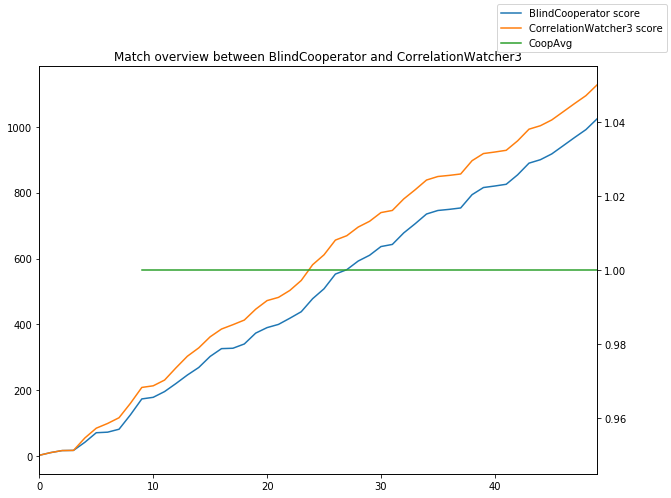

In [21]:
x = Interact(BlindCooperator, CorrelationWatcher5, 50, verbose = 1, vis = 1)

Interaction series no 0. overview-------------------------
BlindDeserter gained 1200.0487992918534 points
BlindCooperator gained 641.3144506522276 points
BlindDeserter cooperativity: 0.0
BlindCooperator cooperativity: 1.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\legend.py:337: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


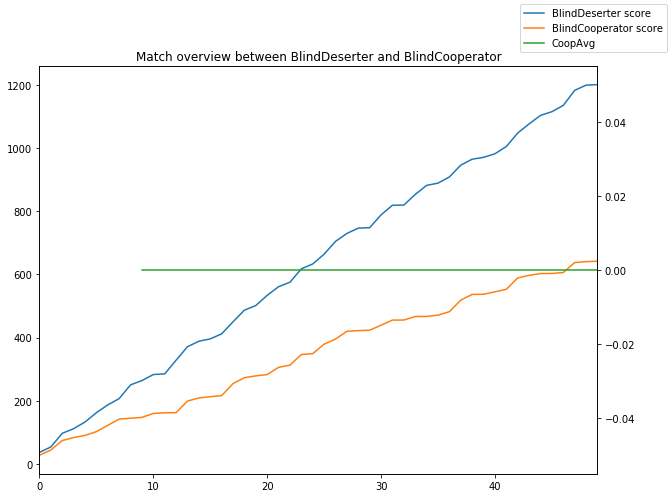

,bot1,bot1 score,bot2,bot2 score,CoopAvg
0,False,36.553225,False,27.502433,NaN
1,False,53.851056,False,44.174903,NaN
2,False,96.882512,False,73.941868,NaN
3,False,111.612918,False,83.411517,NaN
4,False,132.652555,False,90.405958,NaN
5,False,162.122629,False,102.268079,NaN
6,False,186.907303,False,122.154327,NaN
7,False,206.750915,False,141.907002,NaN
8,False,250.190341,False,144.662930,NaN
9,False,263.799059,False,147.387095,0.0


In [22]:
Interact(BlindDeserter, BlindCooperator, 50, verbose = 1, vis = 1)

Interaction series no 0. overview-------------------------
BlindDeserter gained 879.5087417581949 points
DesertionCalculator gained 721.7997531461003 points
BlindDeserter cooperativity: 0.0
DesertionCalculator cooperativity: 0.48


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\legend.py:337: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


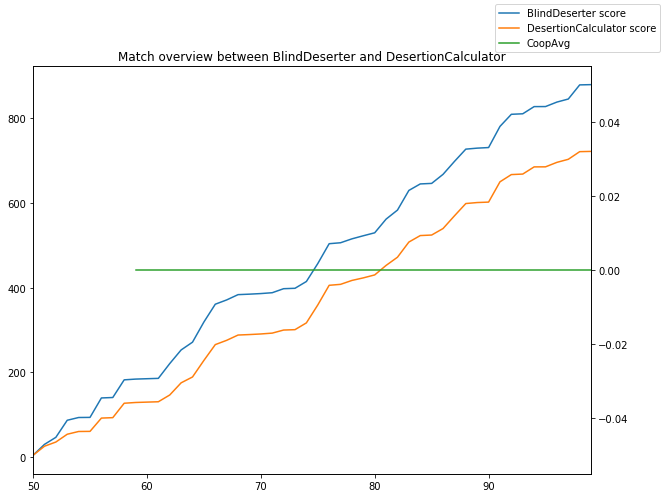

,bot1,bot1 score,bot2,bot2 score,CoopAvg
50,False,3.992242,False,3.992242,NaN
51,False,29.709311,False,25.338607,NaN
52,False,46.351192,False,35.245101,NaN
53,False,86.691757,False,53.658912,NaN
54,False,93.195189,False,60.162345,NaN
55,False,93.467168,False,60.434324,NaN
56,False,139.397901,False,91.813225,NaN
57,False,140.422728,False,92.838053,NaN
58,False,182.142128,False,126.886865,NaN
59,False,183.933212,False,128.677950,0.0


In [23]:
Interact(BlindDeserter, DesertionCalculator, 50, verbose = 1, vis = 1)

Interaction series no 0. overview-------------------------
BlindDeserter gained 730.8654043972551 points
ForgivingPunisher gained 725.2929051272844 points
BlindDeserter cooperativity: 0.0
ForgivingPunisher cooperativity: 0.02


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\legend.py:337: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


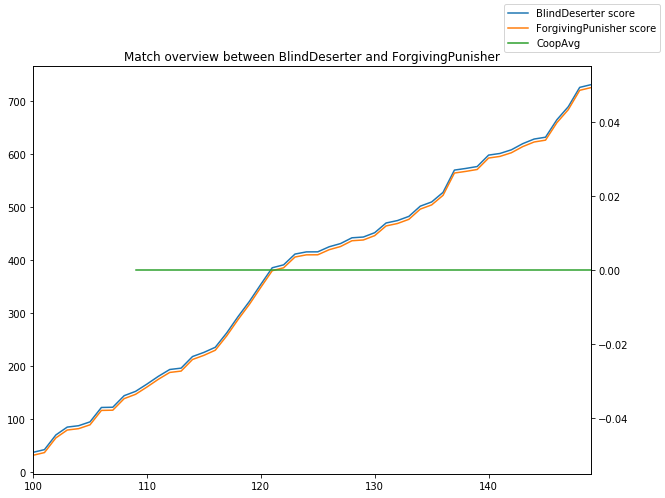

,bot1,bot1 score,bot2,bot2 score,CoopAvg
100,False,36.608189,False,31.035690,NaN
101,False,41.687377,False,36.114878,NaN
102,False,69.365905,False,63.793406,NaN
103,False,84.250485,False,78.677986,NaN
104,False,86.856263,False,81.283764,NaN
105,False,94.106384,False,88.533885,NaN
106,False,121.290653,False,115.718154,NaN
107,False,121.717574,False,116.145075,NaN
108,False,143.580695,False,138.008196,NaN
109,False,151.695742,False,146.123243,0.0


In [24]:
Interact(BlindDeserter, ForgivingPunisher, 50, verbose = 1, vis = 1)

In [519]:
Interact(BlindDeserter, SimpleCalculator, 50, verbose = 1, vis = 1)

Interaction series no 0. overview-------------------------
BlindDeserter gained 654.000850146826 points
SimpleCalculator gained 626.9091347882301 points
BlindDeserter cooperativity: 0.0
SimpleCalculator cooperativity: 0.16
